In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as linalg
import scipy.sparse as sparse
import scipy.sparse.linalg as linalgs
from matplotlib import animation
from IPython.display import HTML

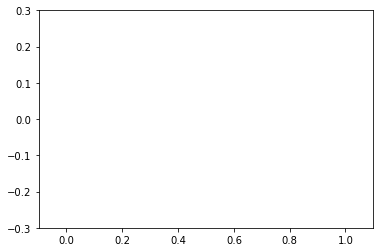

In [2]:
fig, ax = plt.subplots()

ax.set_xlim(( -0.1, 1.1))
ax.set_ylim((- 0.3, 0.3))

line, = ax.plot([], [], lw=2)

nframes = 500

def init():
    line.set_data([], [])
    return (line,)

## String

In [3]:
class StringProb():
    """Class for setting up a string wave eigenvector problem"""
    def p(self, x=None):
        return(1.) 
    def rho(self, x=None):
        return(1.) 
    def q(self, x=None):
        return(0.)
    def __init__(self, N=201, **kwargs):
        self.kwargs = kwargs
        self.N = N
        self.h = 1. / (np.float64(N) + 1.)
        self.x = (np.arange(self.N, dtype=np.float64) + 1.) * self.h
        diagonal = ((self.p(self.x - 0.5 * self.h) +
                     self.p(self.x + 0.5 * self.h)) / self.h**2 
                    + self.q(self.x)) / self.rho(self.x)
        lower_diagonal = - (self.p(self.x[1:] - 0.5 * self.h)) / self.h**2 / self.rho(self.x[1:]) 
        upper_diagonal = - (self.p(self.x[1:] - 0.5 * self.h)) / self.h**2 / self.rho(self.x[0:-1]) 
        self.A = sparse.diags(diagonals=[lower_diagonal, diagonal, upper_diagonal],
                              offsets=[-1, 0, 1], shape=(N, N))
    def eig(self):
        # Note that the sparse version of "eig" failed here; I know this problem should 
        # yield sines and cosines. A lesson to check your package's performance! So I 
        # work on the full matrix.
        vals, vecs = linalg.eig(self.A.toarray())
        isort = np.argsort(vals)
        self.evals = vals[isort]
        self.evecs = vecs[:, isort]
    def set_coeffs(self, a=None, b=None):
        self.a = a
        self.b = b
    def fit_coeffs(self, d=None):
        (u, w, vt) = linalg.svd(self.evecs)
        inz = np.where(w > 1.e-15)[0]
        invw = np.zeros(len(w))
        invw[inz] = 1. / w[inz] 
        einv = vt.transpose().dot(np.diag(invw)).dot(u.transpose())
        return(einv.dot(d)) 
    def frame(self, i):
        period =  2. * np.pi / np.sqrt(self.evals[0])
        t = np.float64(i) / np.float64(nframes) * period * 4
        x = self.x
        coeffs = (self.a * np.cos(np.sqrt(self.evals) * t) +
                  self.b * np.sin(np.sqrt(self.evals) * t))
        y = self.evecs.dot(coeffs).flatten()
        line.set_data(x, y)
        return (line,)


In [4]:
st = StringProb()
st.eig()
print(st.A.toarray())

[[ 81608. -40804.      0. ...,      0.      0.      0.]
 [-40804.  81608. -40804. ...,      0.      0.      0.]
 [     0. -40804.  81608. ...,      0.      0.      0.]
 ..., 
 [     0.      0.      0. ...,  81608. -40804.      0.]
 [     0.      0.      0. ..., -40804.  81608. -40804.]
 [     0.      0.      0. ...,      0. -40804.  81608.]]


In [5]:
print(st.evals[0:30])

[    9.86940547    39.47523472    88.81032688   157.86274912   246.61579948
   355.04801094   483.13315664   630.84025618   798.13358311   984.97267364
  1191.31233632  1417.10266308  1662.28904121  1926.81216665  2210.60805825
  2513.60807331  2835.73892418  3176.92269594  3537.07686528  3916.11432047
  4313.94338239  4730.46782674  5165.58690731  5619.19538033  6091.18352995
  6581.43719474  7089.83779534  7616.26236314  8160.58356999  8722.66975903]


In [6]:
print(np.sqrt(st.evals[0:30] / st.evals[0]))

[  1.           1.99993953   2.99975813   3.99939533   4.99879069
   5.99788378   6.99661418   7.9949215    8.99274538   9.99002546
  10.98670146  11.9827131   12.97800016  13.97250244  14.96615982
  15.9589122   16.95069957  17.94146193  18.93113939  19.91967209
  20.90700026  21.89306421  22.8778043   23.86116098  24.84307479
  25.82348636  26.80233641  27.77956573  28.75511525  29.72892596]


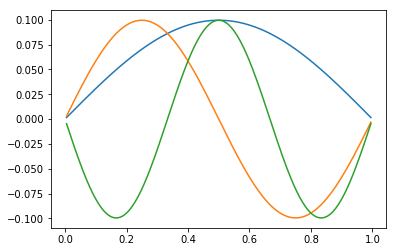

In [7]:
for i in np.arange(3):
    plt.plot(st.x, st.evecs[:, i])

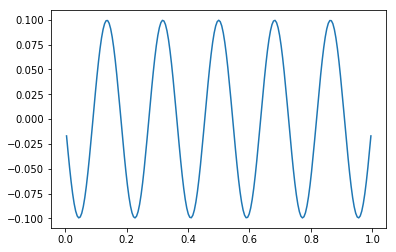

In [8]:
plt.plot(st.x, st.evecs[:, 10])

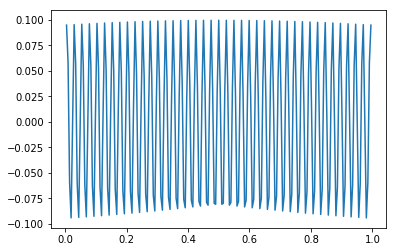

In [9]:
plt.plot(st.x, st.evecs[:, 80])

In [10]:
acoeffs = np.zeros(len(st.evals))
acoeffs[0] = 1.
acoeffs[1] = 0.5
acoeffs[2] = 0.25

bcoeffs = np.zeros(len(st.evals))

st.set_coeffs(a=acoeffs, b=bcoeffs)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, st.frame, init_func=init,
                               frames=nframes, interval=40, blit=True)

HTML(anim.to_html5_video())

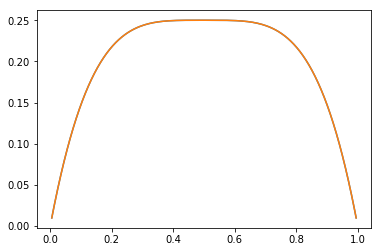

In [11]:
initial = (- (st.x - 0.5)**4 + 0.5**4) * 4.
coeffs = st.fit_coeffs(d=initial)

plt.plot(st.x, initial)
plt.plot(st.x, st.evecs.dot(coeffs))

(-1.0, 10)

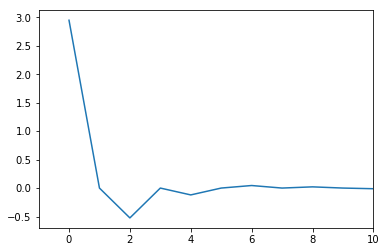

In [12]:
plt.plot(coeffs)
plt.xlim((-1., 10))

In [13]:
st.set_coeffs(a=coeffs, b=bcoeffs)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, st.frame, init_func=init,
                               frames=nframes, interval=40, blit=True)

HTML(anim.to_html5_video())

## String which is a bit springy

In [14]:
class StringProbSpringy(StringProb):
    def q(self, x):
        return(self.kwargs['q0'])

In [15]:
stq = StringProbSpringy(q0=40.1)
stq.eig()

In [16]:
print(stq.A.toarray())

[[ 81648.1 -40804.       0.  ...,      0.       0.       0. ]
 [-40804.   81648.1 -40804.  ...,      0.       0.       0. ]
 [     0.  -40804.   81648.1 ...,      0.       0.       0. ]
 ..., 
 [     0.       0.       0.  ...,  81648.1 -40804.       0. ]
 [     0.       0.       0.  ..., -40804.   81648.1 -40804. ]
 [     0.       0.       0.  ...,      0.  -40804.   81648.1]]


Eigenvalues are higher, which is just saying there is a minimum frequency that is higher, like the dispersion related says must be the case.

In [17]:
print(stq.evals[0:10])

[   49.96940547    79.57523472   128.91032688   197.96274912   286.71579948
   395.14801094   523.23315664   670.94025618   838.23358311  1025.07267364]


In [18]:
print(np.sqrt(stq.evals[0:10] / stq.evals[0]))

[ 1.          1.26193467  1.60617094  1.99039672  2.39537615  2.81208089
  3.23590332  3.66428997  4.09572168  4.52923899]


But the eigenfunctions are the same for the patterns. Note that the way they evolve will be different, because, as just shown above, their frequencies are no longer in a harmonic sequence. 

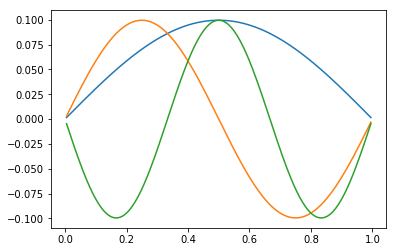

In [19]:
for i in np.arange(3):
    plt.plot(stq.x, stq.evecs[:, i])

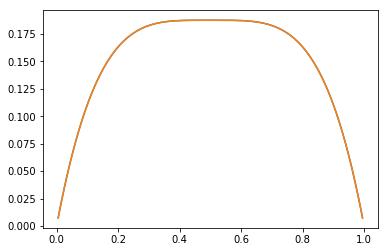

In [20]:
initial = (- (stq.x - 0.5)**4 + 0.5**4) * 3.
coeffs = stq.fit_coeffs(d=initial)

plt.plot(stq.x, initial)
plt.plot(stq.x, stq.evecs.dot(coeffs))

In [21]:
print(coeffs[0:10])

[  2.21036271e+00  -1.25825443e-12  -3.93242990e-01   1.12515059e-13
  -9.03210804e-02   1.50949701e-13  -3.34560685e-02  -4.36905557e-14
  -1.58459196e-02   4.05097912e-14]


In [22]:
stq.set_coeffs(a=coeffs, b=bcoeffs)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, stq.frame, init_func=init,
                               frames=nframes, interval=40, blit=True,
                               repeat_delay=2000)

HTML(anim.to_html5_video())

## String which is heavy in the middle

In [23]:
class StringProbDensity(StringProb):
    def rho(self, x):
        rrho = np.ones(len(x))
        rrho[(x > 0.40) & (x < 0.60)] = 1. + self.kwargs['rhocen']
        return(rrho)

In [24]:
std = StringProbDensity(rhocen=4., N=1001)
std.eig()

In [25]:
print(std.A.toarray())

[[ 2008008. -1004004.        0. ...,        0.        0.        0.]
 [-1004004.  2008008. -1004004. ...,        0.        0.        0.]
 [       0. -1004004.  2008008. ...,        0.        0.        0.]
 ..., 
 [       0.        0.        0. ...,  2008008. -1004004.        0.]
 [       0.        0.        0. ..., -1004004.  2008008. -1004004.]
 [       0.        0.        0. ...,        0. -1004004.  2008008.]]


In [26]:
print(std.evals[0:10])

[   3.71172206   30.80006891   59.09386571   89.18529322  168.71301949
  236.20848439  289.04875058  416.09086115  530.82932375  604.94449055]


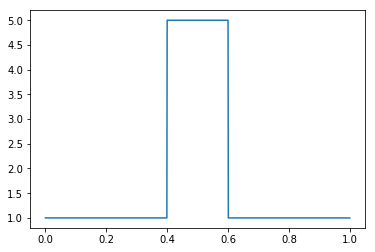

In [27]:
plt.plot(std.x, std.rho(std.x))

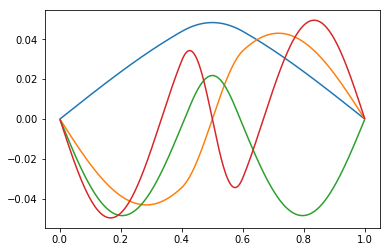

In [28]:
for i in np.arange(4):
    plt.plot(std.x, std.evecs[:, i])

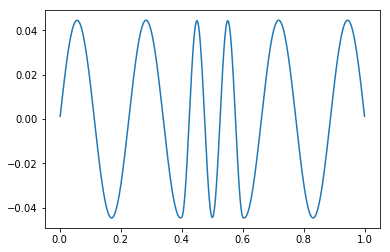

In [29]:
plt.plot(std.x, std.evecs[:, 10])

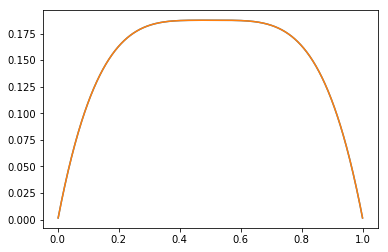

In [30]:
initial = (- (std.x - 0.5)**4 + 0.5**4) * 3.
coeffs = std.fit_coeffs(d=initial)

plt.plot(std.x, initial)
plt.plot(std.x, std.evecs.dot(coeffs))

In [31]:
bcoeffs = np.zeros(std.N)

std.set_coeffs(a=coeffs, b=bcoeffs)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, std.frame, init_func=init,
                               frames=nframes, interval=40, blit=True,
                               repeat_delay=2000)

HTML(anim.to_html5_video())

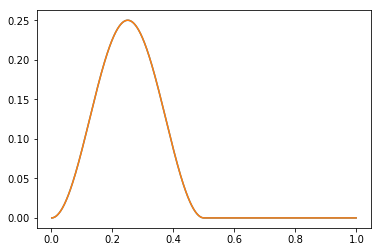

In [34]:
initial = np.zeros(std.N)
half = np.arange(std.N // 2)
initial[half] = np.sin(np.pi * std.x[half] / 0.5)**2 * 0.25
coeffs = std.fit_coeffs(d=initial)

plt.plot(std.x, initial)
plt.plot(std.x, std.evecs.dot(coeffs))

In [35]:
bcoeffs = np.zeros(std.N)

std.set_coeffs(a=coeffs, b=bcoeffs)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, std.frame, init_func=init,
                               frames=nframes, interval=40, blit=True,
                               repeat_delay=2000)

HTML(anim.to_html5_video())

(0.0, 100.0)

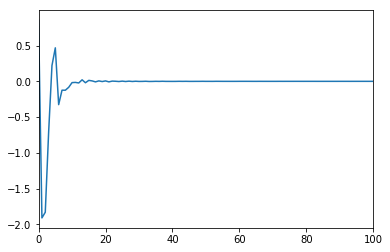

In [38]:
plt.plot(coeffs)
plt.xlim((0., 100.))